In [1]:
%pylab inline
#%%writefile ../crypto_chaotic/audioClient.py
#!/usr/bin/env python

import pyaudio
import wave
from twisted.internet.protocol import DatagramProtocol
from twisted.internet import reactor
import numpy as np
from crypto_chaotic.modulation import drawfft
from matplotlib import rcParams
import matplotlib.pyplot as plt
from random import randrange
from crypto_chaotic import lorenz_attractor, modulation
from scipy.fftpack import rfft, irfft, fftfreq

CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
RECORD_SECONDS = 20

tstep = 0.01
ndrop = 1500
N = 4

Amplification = 5000
#WAVE_OUTPUT_FILENAME = "output.wav"

class EchoClientDatagramProtocol(DatagramProtocol):
    p = pyaudio.PyAudio()

    inputStream = p.open(format=FORMAT,
                         channels=CHANNELS,
                         rate=RATE,
                         input=True,
                         frames_per_buffer=CHUNK)

    outputStream = p.open(format=FORMAT,
                          channels=CHANNELS,
                          rate=RATE,
                          output=True)
    
    inputStream.stop_stream()
    sndframectr = 0
    rcvframectr = 0
    xt = np.zeros(CHUNK, dtype=np.float64)
    xr = np.zeros(CHUNK, dtype=np.float64)
    buff = np.array([],  dtype=np.int16)
    voicebuff = []
    
    def startProtocol(self):
        self.transport.connect('192.168.10.1', 8000)
        self.sendDatagram()
    
    def sendDatagram(self):
        #print self.framectr
        if self.sndframectr <= int(RATE / CHUNK * RECORD_SECONDS):#if len(self.strings):
            
            if self.sndframectr == 0:
                data = np.zeros(CHUNK, dtype=np.int16).tostring()
            else:
                data = self.inputStream.read(CHUNK)
            
            #########################################
            ###     Voice Data                    ###
            #########################################
            modsig = np.fromstring(data, dtype=np.int16)

            #########################################
            ###         Frequency Domain          ###
            #########################################
            d=(1.0 * CHUNK)/RATE
            #W = fftfreq(modsig.size, d=RATE/CHUNK)
            f_signal = rfft(modsig)

            #########################################
            ###              Filter               ###
            #########################################
            minm = 100*d
            maxm = 18000*d
            cut_f_signal = f_signal.copy()
            for j in range(len(cut_f_signal)):
                if j < minm:
                    cut_f_signal[j] = 0
                elif j > maxm:
                    cut_f_signal[j] = 0

            #########################################
            ###     Time Domain Amplification     ###
            #########################################
            self.tcut_signal0 = irfft(cut_f_signal)
            cut_signal = np.array(self.tcut_signal0/Amplification, dtype=np.float64)

            #########################################
            ###           Chaos Encrypt           ###
            #########################################
            if self.sndframectr == 0:
                encryptedx, xt = lorenz_attractor.chaos_encrypt(np.zeros(CHUNK, dtype=np.float64), 
                                                                N = N, tstep = tstep, ndrop = ndrop)
                print 'encryptedx:', len(encryptedx)
                print len(xt)
                self.xt = np.append(xt[-CHUNK/2:], xt[-CHUNK/2:])
                self.inputStream.start_stream()
            else:
                encryptedx = cut_signal + self.xt
            
            self.transport.write(encryptedx.tostring())
            if self.rcvframectr == 2:
                modulation.plotamp([self.xt, encryptedx, cut_signal], xmin = 0, xmax = 0)
                modulation.drawfft([self.xt, encryptedx, cut_signal], xlow=0, xhigh=0, ylow=0, yhigh=0)
                #self.transport.write(cut_signal.tostring())
        else:
            self.inputStream.stop_stream()
            self.inputStream.close()
            self.outputStream.stop_stream()
            self.outputStream.close()
            self.p.terminate()
            reactor.stop()
        self.sndframectr += 1

    def datagramReceived(self, datagram, host):
        #print 'Datagram received: ', repr(datagram)
        if self.outputStream:
            encryptedx = np.fromstring(datagram, dtype=np.float64) #, dtype=np.int16)
            if self.rcvframectr == 0:
                print 'encryptedx:', len(encryptedx)
                recovered, xr = lorenz_attractor.chaos_decrypt(encryptedx, 
                                                                    N = N, tstep = tstep, ndrop = ndrop)                
                print len(xr)
                self.xr = np.append(xr[-CHUNK/2:], xr[-CHUNK/2:])
            else:
                recovered = encryptedx - self.xr
                
            #########################################
            ###     Time Domain Amplification     ###
            #########################################
            recovered_amp = recovered * Amplification
            recovered_buff = np.array(recovered_amp.astype(int), dtype=np.int16)

            #########################################
            ###         Frequency Domain          ###
            #########################################
            d=(1.0 * CHUNK)/RATE
            #W = fftfreq(modsig.size, d=RATE/CHUNK)
            f_signal = rfft(recovered_buff)

            #########################################
            ###              Filter               ###
            #########################################
            minm = 100*d
            maxm = 18000*d
            cut_f_signal = f_signal.copy()
            for j in range(len(cut_f_signal)):
                if j < minm:
                    cut_f_signal[j] = 0
                elif j > maxm:
                    cut_f_signal[j] = 0

            #########################################
            ###             Time Domain           ###
            #########################################
            self.rcut_signal0 = irfft(cut_f_signal)
            cut_signal = np.array(self.rcut_signal0.astype(int), dtype=np.int16)
    
            self.outputStream.write(cut_signal.tostring())
            if self.rcvframectr == 2:
                modulation.plotamp([self.xt, self.xr], xmin = 0, xmax = 0)
                modulation.drawfft([self.xt, self.xr], xlow=0, xhigh=0, ylow=0, yhigh=0)
                modulation.plotamp([self.tcut_signal0, self.rcut_signal0], xmin = 0, xmax = 0)
                modulation.drawfft([self.tcut_signal0, self.rcut_signal0], xlow=0, xhigh=0, ylow=0, yhigh=0)
                
            self.rcvframectr += 1
            
        self.sendDatagram()

def main():
    protocol = EchoClientDatagramProtocol()
    t = reactor.listenUDP(0, protocol)
    reactor.run()

#if __name__ == '__main__':
#    main()

Populating the interactive namespace from numpy and matplotlib


encryptedx: 1024
1024
encryptedx: 1024
1024
0 -1


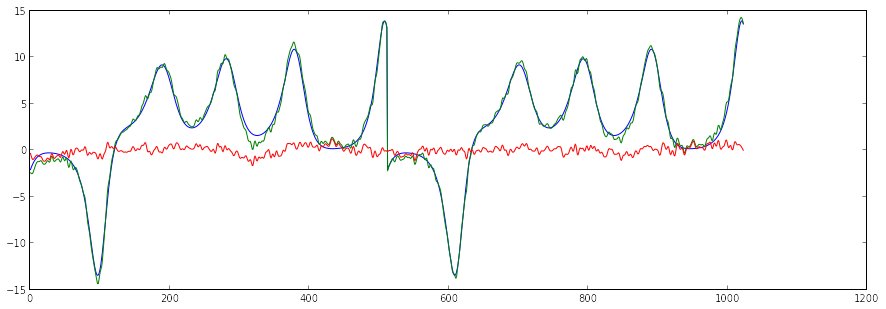

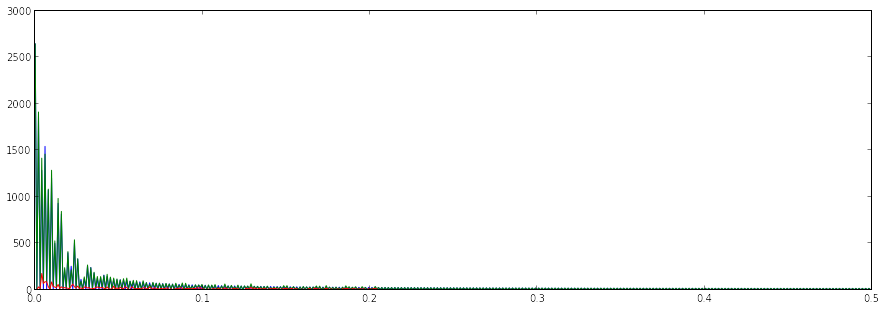

0 -1


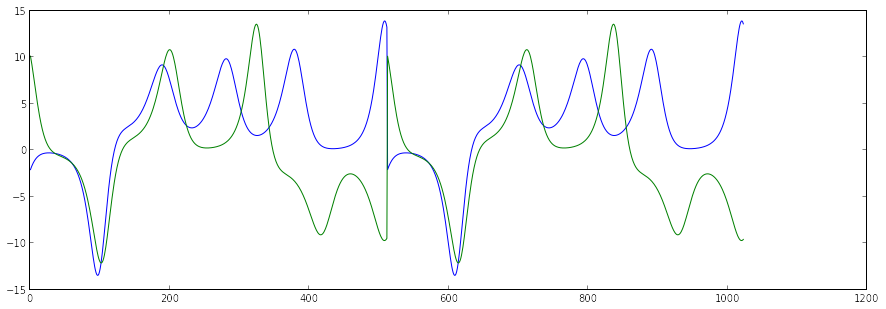

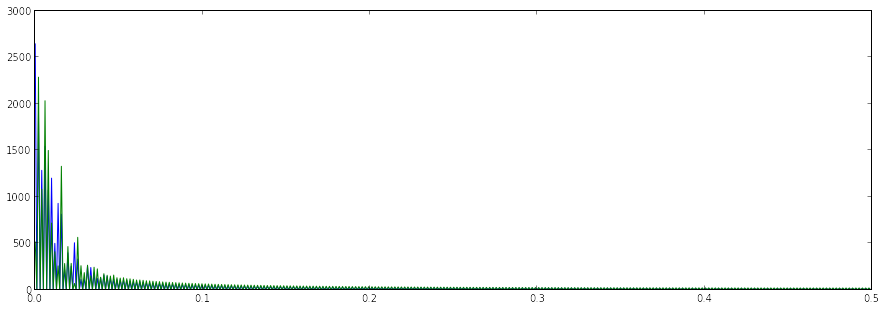

0 -1


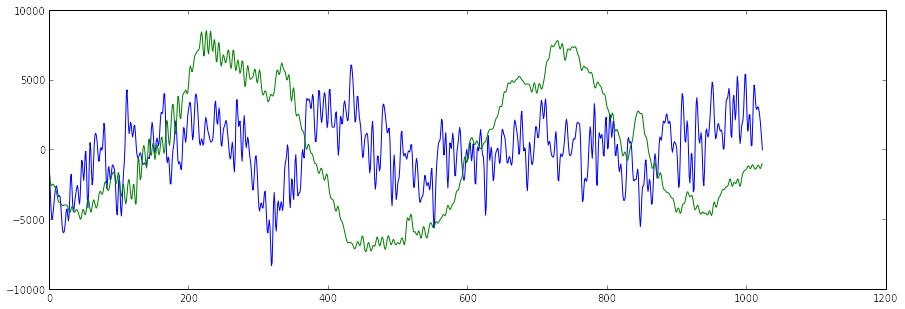

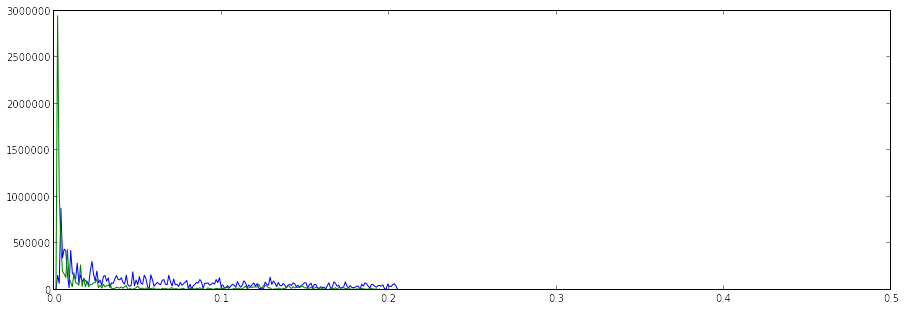

In [2]:
protocol = EchoClientDatagramProtocol()
t = reactor.listenUDP(0, protocol)
reactor.run()

In [ ]:
print protocol.buff

In [ ]:

import matplotlib.pyplot as plt

x = range(len(protocol.buff[:100]))

plt.figure(figsize=(15, 5))
#fft = np.fft(encryptedx)

plt.plot(x,protocol.buff[:100])
plt.show()

In [ ]:
def drawfft(signals, xlow=0, xhigh=0, ylow=0, yhigh=0):
    plt.figure(figsize=(15, 5))    
    if xlow < xhigh:
        plt.xlim([xlow,xhigh])
    if ylow < yhigh:
        plt.ylim([ylow,yhigh])
        
    for i in signals:
        sp = np.abs(np.fft.fft(i))
        freq = np.fft.fftfreq(len(sp), 1)

        Nindex = np.argmax(freq < 0)
        freq1 = freq[:Nindex]
        sp1 = sp[:Nindex]
        plt.plot(freq1, sp1)
    plt.show()

In [ ]:
drawfft([protocol.buff])

In [ ]:
p = pyaudio.PyAudio()
buff = protocol.buff.tostring()
outputStream = p.open(format=FORMAT,
                      channels=CHANNELS,
                      rate=RATE,
                      output=True)

outputStream.write(buff)
outputStream.stop_stream()
outputStream.close()

In [ ]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
from random import randrange
from crypto_chaotic import lorenz_attractor, modulation
from scipy.fftpack import rfft, irfft, fftfreq

tstep = 0.1
ndrop = 15
N = 4

p = pyaudio.PyAudio()
buff = protocol.buff.tostring()
outputStream = p.open(format=FORMAT,
                      channels=CHANNELS,
                      rate=RATE,
                      output=True)
recovered_buff = np.array([],  dtype=np.int16)
for i in protocol.voicebuff:

    #########################################
    ###     Voice Data                    ###
    #########################################
    signal = np.fromstring(i, dtype=np.int16) #np.array([randrange(0, 2**64) for i in range(nosdata)], dtype=np.uint64)
    #signal = np.array([0x0123456789abcdef, 0x0123456789abcdef], dtype=np.uint64)

    #########################################
    ###          QPSK Modulation          ###
    #########################################
    modsig = signal #modulation.qpsk_modulate(signal, p = p, sampling = sampling, E=E)

    #########################################
    ###         Frequency Domain          ###
    #########################################
    d=(1.0 * CHUNK)/RATE
    W = fftfreq(modsig.size, d=RATE/CHUNK)
    #print d
    f_signal = rfft(modsig)

    #########################################
    ###              Filter               ###
    #########################################
    minm = 100*d
    maxm = 18000*d
    cut_f_signal = f_signal.copy()
    for j in range(len(cut_f_signal)):
        if j < minm:
            cut_f_signal[j] = 0
        elif j > maxm:
            cut_f_signal[j] = 0

    #########################################
    ###            Time Domain            ###
    #########################################
    cut_signal0 = irfft(cut_f_signal)
    cut_signal = np.array(cut_signal0/10000, dtype=np.float64)

    #########################################
    ###           Chaos Encrypt           ###
    #########################################
    encryptedx, xt = lorenz_attractor.chaos_encrypt(cut_signal, N = N, tstep = tstep, ndrop = ndrop)

    recovered, xr = lorenz_attractor.chaos_decrypt(encryptedx, N = N, tstep = tstep, ndrop = ndrop)
    #outputStream.write(i)
    encryptedx_amp = encryptedx * 10000    
    recovered_amp = recovered * 10000
    
    recovered_buff = np.append(recovered_buff, np.array(recovered_amp.astype(int), dtype=np.int16))
    #buff = np.array(recovered_amp.astype(int), dtype=np.int16)
outputStream.write(recovered_buff.tostring())
    
outputStream.stop_stream()
outputStream.close()

modulation.plotamp([cut_signal, cut_signal0], xmin = 0, xmax = 0)
modulation.plotamp([encryptedx, xt, cut_signal], xmin = 0, xmax = 0)
modulation.plotamp([xt], xmin = 0, xmax = 0)
modulation.drawfft([encryptedx, xt, cut_signal], xlow=0, xhigh=0, ylow=0, yhigh=0)

In [ ]:
print cut_signal.astype(int), modsig

In [ ]:
print f_signal.size

In [ ]:

modulation.drawfft([encryptedx, xt, cut_signal], xlow=0, xhigh=0, ylow=0, yhigh=0)